**Universidade Tecnológica Federal do Paraná**

**Programa de Pós-Graduação em Informática (PPGI)**

**Disciplina:** Linguagens de Programação

**Professores:** Dr. Adriano Rivolli (UTFPR-CP) e Dr. Marlon Marcon (UTFPR-DV)

**Aluno:** Wellington Guimarães de Almeida


# Projeto Avaliativo


## Descrição do projeto


##Pré-requisitos

Para a realização deste projeto faz-se necessário a instalação e importação das seguintes bibliotecas:

-   [Pandas](https://pandas.pydata.org/) - Biblioteca de análise e manipulação de dados
-   [Matplotlib](https://matplotlib.org/) - Biblioteca para criação de visualizações de dados
-   [NumPy](https://numpy.org/) - Biblioteca para realização de cálculos numéricos
-   [ipywidgets](https://github.com/jupyter-widgets/ipywidgets) - Biblioteca de componentes visuais interativos
-   [Geopandas](https://geopandas.org/) - Biblioteca para manipulação de dados geoespaciais
-   [geobr](https://github.com/ipeaGIT/geobr) - Biblioteca de dados geoespaciais brasileiros

<!--
- [Descartes](https://pypi.org/project/descartes/) - Biblioteca para plotagem de objetos geométricos no matplotlib -->


### Instalação das bibliotecas necessárias


In [53]:
!pip install pandas
!pip install matplotlib
!pip install numpy
!pip install ipywidgets
!pip install geopandas
!pip install geobr
!pip install descartes


###Importação das bibliotecas necessárias


In [54]:
import pandas as pd
import ipywidgets as widgets
import matplotlib.pyplot as plt
import geopandas as gpd
import geobr


##Definição de parâmetros da análise

A análise realizada neste projeto tem seu escopo restrito à unidade da federação selecionada a seguir.


In [55]:
uf_list = ['AC', 'AL', 'AM', 'AP', 'BA', 'CE', 'DF', 'ES', 'GO', 'MA', 'MG', 'MS', 'MT',
           'PA', 'PB', 'PE', 'PI', 'PR', 'RJ', 'RN', 'RO', 'RR', 'RS', 'SC', 'SE', 'SP', 'TO']

# Definição de parâmetros
titulo = widgets.Label('Selecione o escopo da análise:')

uf_select = widgets.Dropdown(
    options=uf_list,
    value='PR',
    description='Estado: ')

widgets.VBox([titulo, uf_select])


##Desenvolvimento


###Carga dos dados


In [56]:
# Função para recuperação dos dados brutos das antenas
def carrega_dados_uf_selecionada(uf):
    url_antenas = 'https://github.com/WellingtonAlmeida/erbs/raw/main/dados-anatel/'+uf+'.csv'
    df_antenas = pd.read_csv(url_antenas, sep=';')
    return df_antenas


# Função para recuperação dos dados de municípios
def carrega_dados_municipios():
    url_municipios = 'https://github.com/WellingtonAlmeida/erbs/raw/main/populacao-municipios.csv'
    df_municipios = pd.read_csv(url_municipios, sep=';')
    return df_municipios


def carrega_dados(uf):
    df_antenas = carrega_dados_uf_selecionada(uf.lower())
    df_municipios = carrega_dados_municipios()
    return df_antenas, df_municipios


df_antenas, df_municipios = carrega_dados(uf_select.value)

/tmp/ipykernel_29752/3775790772.py:16: DtypeWarning: Columns (13,18,19,20,22,23,24,28,29,35,38) have mixed types.Specify dtype option on import or set low_memory=False.
  df_antenas = carrega_dados_uf_selecionada(uf.lower())


In [57]:
# Verificação da carga de dados das antenas
df_antenas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60426 entries, 0 to 60425
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Status.state                 60426 non-null  object 
 1   NomeEntidade                 60426 non-null  object 
 2   NumFistel                    60426 non-null  int64  
 3   NumServico                   60426 non-null  int64  
 4   NumAto                       60426 non-null  int64  
 5   NumEstacao                   60426 non-null  int64  
 6   EnderecoEstacao              60408 non-null  object 
 7   EndComplemento               13893 non-null  object 
 8   SiglaUf                      60426 non-null  object 
 9   CodMunicipio                 60411 non-null  float64
 10  DesignacaoEmissao            60426 non-null  object 
 11  Tecnologia                   60426 non-null  object 
 12  tipoTecnologia               1727 non-null   object 
 13  meioAcesso      

In [58]:
# Verificação da carga de dados dos municípios
df_municipios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5570 entries, 0 to 5569
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   UF              5570 non-null   object
 1   COD_UF          5570 non-null   int64 
 2   COD_MUNIC       5570 non-null   int64 
 3   NOME_MUNICIPIO  5570 non-null   object
 4   POPULACAO       5570 non-null   object
dtypes: int64(2), object(3)
memory usage: 217.7+ KB


### Tratamento dos dados


In [59]:
# Tratamento dos dados de antenas
def trata_dados_antenas(df):
    # Seleção das colunas utilizadas na análise
    colunas = ['NomeEntidade', 'NumEstacao', 'SiglaUf', 'CodMunicipio', 'Tecnologia',  'AlturaAntena',
               'PotenciaTransmissorWatts', 'DataLicenciamento', 'DataPrimeiroLicenciamento', 'Latitude', 'Longitude']
    df_antenas = df[colunas]

    # Atribuição de novos nomes às colunas
    novos_nomes_colunas = ['operadora', 'estacao', 'uf', 'codigo_municipio', 'tecnologia', 'altura_antena',
                           'potencia_transmissor', 'data_licenciamento', 'data_primeiro_licenciamento', 'latitude', 'longitude']
    df_antenas.columns = novos_nomes_colunas

    # Descarte dos registros com dados incompletos
    df_antenas = df_antenas.dropna()

    # Descarta registros com coordenadas fora do limite nacional
    LIMITE_NORTE = 6
    LIMITE_SUL = -34
    LIMITE_LESTE = -35
    LIMITE_OESTE = -73
    selecao = df_antenas[df_antenas['latitude'] > LIMITE_NORTE].index
    df_antenas.drop(selecao, inplace=True)
    selecao = df_antenas[df_antenas['latitude'] < LIMITE_SUL].index
    df_antenas.drop(selecao, inplace=True)
    selecao = df_antenas[df_antenas['longitude'] > LIMITE_LESTE].index
    df_antenas.drop(selecao, inplace=True)
    selecao = df_antenas[df_antenas['longitude'] < LIMITE_OESTE].index
    df_antenas.drop(selecao, inplace=True)

    # Ajuste nos tipos de dados
    df_antenas['codigo_municipio'] = df_antenas['codigo_municipio'].astype(int)
    df_antenas['data_licenciamento'] = pd.to_datetime(
        df_antenas['data_licenciamento'], format='%Y-%m-%d')
    df_antenas['data_primeiro_licenciamento'] = pd.to_datetime(
        df_antenas['data_primeiro_licenciamento'], format='%Y-%m-%d')
    return df_antenas

# Tratamento dos dados de municípios
def trata_dados_municipios(df, uf):
    df_municipios = df[df['UF'] == uf.upper()]
    # Ajusta colunas da tabela de município
    novos_nomes_colunas = ['uf', 'codigo_uf',
                           'codigo_municipio', 'municipio', 'populacao']
    df_municipios.columns = novos_nomes_colunas
    df_municipios['codigo_municipio'] = (
        df_municipios['codigo_uf']*100000)+df_municipios['codigo_municipio']
    df_municipios.drop(columns=['codigo_uf'], inplace=True)
    return df_municipios

# Cria dataframe de ERB's
def cria_dataframe_erbs(df_antenas, df_municipios):
    return df_antenas.merge(df_municipios)


def trata_dados(df_antenas_bruto, df_municipios_bruto):
    df_antenas = trata_dados_antenas(df_antenas_bruto)
    df_municipios = trata_dados_municipios(df_municipios_bruto, uf_select.value)
    df_erbs = cria_dataframe_erbs(df_antenas, df_municipios)
    return df_antenas, df_municipios, df_erbs

df_antenas, df_municipios, df_erbs = trata_dados(df_antenas, df_municipios)


/tmp/ipykernel_29752/4005567890.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_municipios['codigo_municipio'] = (
/home/wellington/.local/lib/python3.8/site-packages/pandas/core/frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [60]:
# Verificação do tratamento dos dados de antenas
df_antenas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57389 entries, 0 to 60425
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   operadora                    57389 non-null  object        
 1   estacao                      57389 non-null  int64         
 2   uf                           57389 non-null  object        
 3   codigo_municipio             57389 non-null  int64         
 4   tecnologia                   57389 non-null  object        
 5   altura_antena                57389 non-null  float64       
 6   potencia_transmissor         57389 non-null  object        
 7   data_licenciamento           57389 non-null  datetime64[ns]
 8   data_primeiro_licenciamento  57389 non-null  datetime64[ns]
 9   latitude                     57389 non-null  float64       
 10  longitude                    57389 non-null  float64       
dtypes: datetime64[ns](2), float64(3), int64(2

In [61]:
#Verificação do tratamento dos dados de municípios
df_municipios.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 399 entries, 3912 to 4310
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   uf                399 non-null    object
 1   codigo_municipio  399 non-null    int64 
 2   municipio         399 non-null    object
 3   populacao         399 non-null    object
dtypes: int64(1), object(3)
memory usage: 15.6+ KB


In [62]:
# Verificação dos dados de ERB's
df_erbs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57389 entries, 0 to 57388
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   operadora                    57389 non-null  object        
 1   estacao                      57389 non-null  int64         
 2   uf                           57389 non-null  object        
 3   codigo_municipio             57389 non-null  int64         
 4   tecnologia                   57389 non-null  object        
 5   altura_antena                57389 non-null  float64       
 6   potencia_transmissor         57389 non-null  object        
 7   data_licenciamento           57389 non-null  datetime64[ns]
 8   data_primeiro_licenciamento  57389 non-null  datetime64[ns]
 9   latitude                     57389 non-null  float64       
 10  longitude                    57389 non-null  float64       
 11  municipio                    57389 non-nu

### Análise e Visualização dos dados


#### Total de antenas por operadora e por tecnologia no Estado

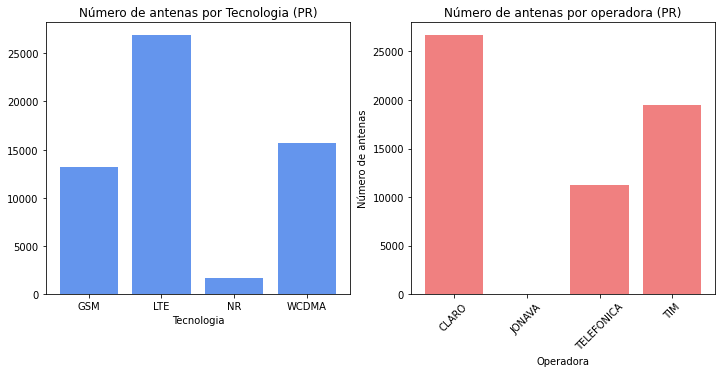

In [98]:
def gera_grafico_antenas():
    df_tecnologia = df_erbs.groupby(['tecnologia']).agg(
        {'estacao': 'count'}).reset_index()
    tecnologia = df_tecnologia['tecnologia'].to_list()
    numero_antenas_tecnologia = df_tecnologia['estacao'].to_list()

    df_operadora = df_erbs.groupby(['operadora']).agg({'estacao': 'count'}).reset_index()
    operadora = [o.split()[0] for o in df_operadora['operadora'].to_list()]
    numero_antenas_operadora = df_operadora['estacao'].to_list()

    fig = plt.figure(figsize=(12, 5))
    axs = fig.subplots(1, 2)

    axs[0].bar(tecnologia, numero_antenas_tecnologia,  color='cornflowerblue')
    axs[0].set_title(
        'Número de antenas por Tecnologia ('+uf_select.value.upper()+')')
    axs[0].set_xlabel('Tecnologia')

    axs[1].bar(operadora, numero_antenas_operadora, color='lightcoral')
    axs[1].set_title('Número de antenas por operadora ('+uf_select.value.upper()+')')
    axs[1].set_xlabel('Operadora')

    plt.ylabel('Número de antenas')
    plt.xticks(rotation=45)
    plt.show()


gera_grafico_antenas()


#### Número de antenas por tecnologia de cada operadora no Estado


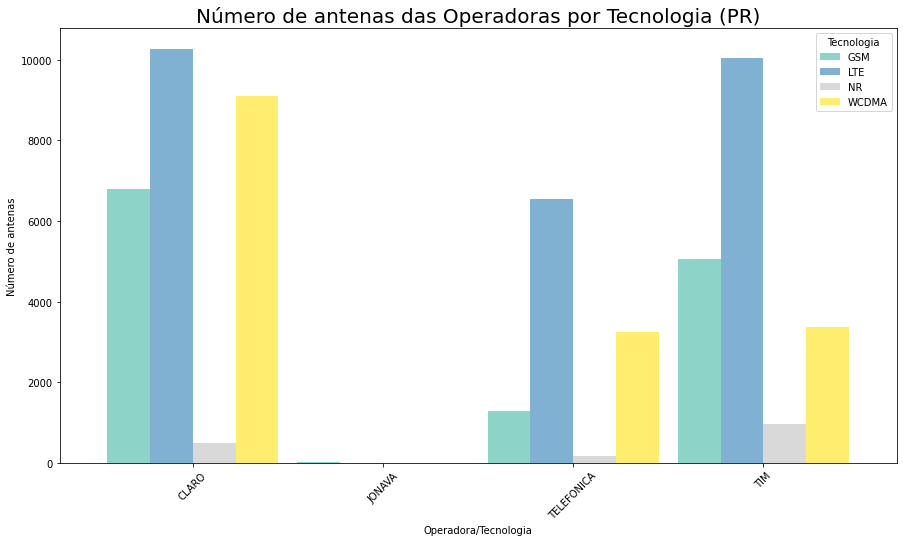

In [90]:
def gera_grafico_antenas_por_tecnologia_agrupado_por_operadora():    
    df = df_erbs
    df['operadora'] = [o.split()[0] for o in df['operadora']]
    df = df_erbs.groupby(['operadora', 'tecnologia']).agg(
        {'estacao': 'count'}).reset_index()   
    df = df.pivot(index='operadora', columns='tecnologia', values='estacao')
    df.fillna(0)

    fig = plt.figure(figsize=(15,8))
    ax = fig.add_subplot()
    df.plot(ax=ax, kind='bar', cmap='Set3', width=0.9)

    plt.title('Número de antenas das Operadoras por Tecnologia ('+uf_select.value.upper()+')', fontsize=20)
    plt.xlabel('Operadora/Tecnologia')
    plt.ylabel('Número de antenas')
    plt.xticks(rotation=45)
    plt.legend(title='Tecnologia')
    plt.show()


gera_grafico_antenas_por_tecnologia_agrupado_por_operadora()


####Localização das ERB's


/home/wellington/.local/lib/python3.8/site-packages/geopandas/plotting.py:33: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
/home/wellington/.local/lib/python3.8/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/wellington/.local/lib/python3.8/site-packages/geopandas/geodataframe.py:34: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  out = from_shapely(data)


<Figure size 3000x3000 with 0 Axes>

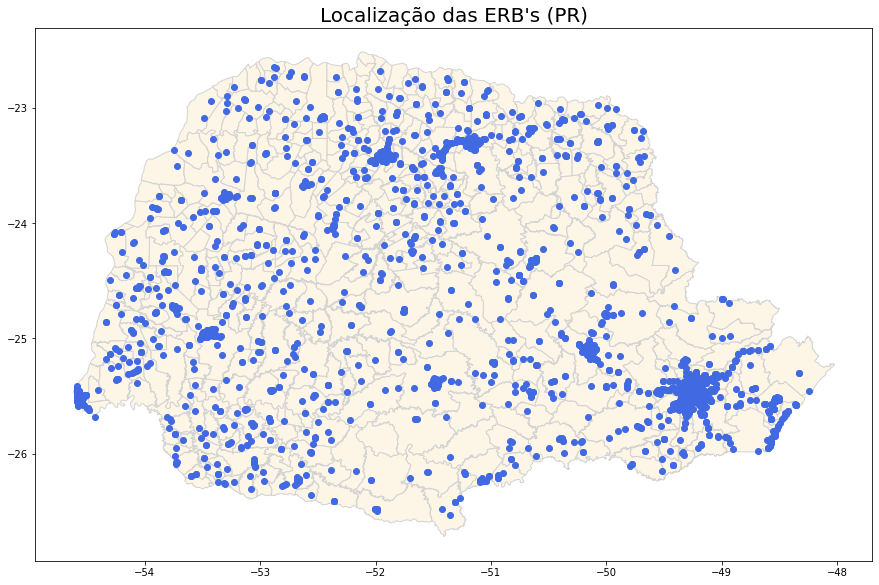

In [73]:
def gera_grafico_localizacao_erbs():    
    uf = uf_select.value.upper()
    plt.figure(figsize=(10,10), dpi=300)
    limite_estado = geobr.read_state(code_state=uf)
    limite_municipios = geobr.read_municipality(code_muni=uf)

    ax = limite_municipios.plot(color='oldlace', edgecolor='lightgray', figsize=(15,15))    

    plt.title('Localização das ERB\'s ('+uf+')', fontsize=20)

    erbs = df_erbs[['estacao', 'latitude', 'longitude']].drop_duplicates()
    gdf = gpd.GeoDataFrame(erbs, geometry=gpd.points_from_xy(
        erbs.longitude, erbs.latitude))
    filtro = gdf.within(limite_estado.loc[0, 'geometry'])
    gdf = gdf.loc[filtro]
    gdf.plot(ax=ax, color='royalblue')
    plt.show()

gera_grafico_localizacao_erbs()